<a href="https://colab.research.google.com/github/z-gard/analysis/blob/main/notebooks/environment_score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 周辺環境スコア
- input
    - park_score.csv
        - 公園スコア
    - sports_score.csv
        - 運動場スコア
        - 体育館スコア
        - プールスコア
- output
    - environment_score.csv
        - 周辺環境スコア


In [1]:
!pip install -q japanize-matplotlib

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
DIR_NAME = '/content/drive/MyDrive/z-gard/data'

In [4]:
import os
import requests
import json
import pandas as pd
from urllib.parse import urlparse, quote
import io
import math
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

In [5]:
score_name = '周辺環境スコア'
output_score_file = 'environment_score.csv'

### 人口マスタ

In [6]:
df_pop_master = pd.read_csv(os.path.join(DIR_NAME, 'population_master.csv'))[[
    '地域ID', '市区町村名', '町名', '町丁目'
]].set_index('地域ID')
print(df_pop_master.shape)

(3145, 3)


### 公園スコア

In [7]:
df_park_score = pd.read_csv(os.path.join(DIR_NAME, 'park_score.csv'))[[
    '地域ID', '公園スコア',
]].set_index('地域ID')
print(df_park_score.shape)

(3145, 1)


In [8]:
df_park_score.head()

,公園スコア
地域ID,
101003,1.487
101004,1.372
101005,1.791
101007,1.856
101008,1.945


### スポーツ施設

In [9]:
df_sports_score = pd.read_csv(os.path.join(DIR_NAME, 'sports_score.csv'))[[
    '地域ID', '運動場スコア', '体育館スコア', 'プールスコア',
]].set_index('地域ID')
print(df_sports_score.shape)

(1839, 3)


In [10]:
df_sports_score.head()

,運動場スコア,体育館スコア,プールスコア
地域ID,,,
103003,2.900,0.370,4.060
103004,3.408,0.432,4.281
103005,3.422,0.457,4.332
103006,3.713,0.515,3.958
103007,3.536,0.635,3.980


In [11]:
def rank_score(sr_data):
    size = sr_data.notna().sum()
    rank = sr_data.rank()
    result = rank.copy()
    # 0~1: 15%, 1~2: 20%, 2~3: 30%, 3~4: 20%, 4~5: 15%
    level_list = [0.15, (0.15+0.2), (0.15+0.2+0.3), (0.15+0.2+0.3+0.2), 1]
    
    pre_level = 0
    for index, level in enumerate([lv*size for lv in level_list]):
        result[(rank > pre_level)&(rank <= level)] = (rank - pre_level)/(level - pre_level) + index
        pre_level = level

    return result

### 周辺環境スコア

In [12]:
df_score = pd.concat([
    df_pop_master,
    df_park_score,
    df_sports_score
], axis=1)
print(df_score.shape)
assert len(df_score) == len(df_pop_master)
df_pop_master = df_score

(3145, 7)


In [13]:
print(df_pop_master.shape)
df_pop_master.head()

(3145, 7)


,市区町村名,町名,町丁目,公園スコア,運動場スコア,体育館スコア,プールスコア
地域ID,,,,,,,
101003,千代田区,丸の内,丸の内１丁目,1.487,NaN,NaN,NaN
101004,千代田区,丸の内,丸の内２丁目,1.372,NaN,NaN,NaN
101005,千代田区,丸の内,丸の内３丁目,1.791,NaN,NaN,NaN
101007,千代田区,大手町,大手町１丁目,1.856,NaN,NaN,NaN
101008,千代田区,大手町,大手町２丁目,1.945,NaN,NaN,NaN


In [14]:
feature_list = {
    '公園スコア': {'sort': 1, 'weight': 1},
    '運動場スコア': {'sort': 1, 'weight': 0.3},
    '体育館スコア': {'sort': 1, 'weight': 0.3},
    'プールスコア': {'sort': 1, 'weight': 0.3},
}

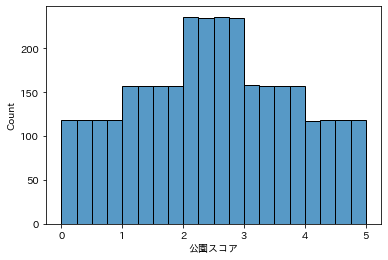

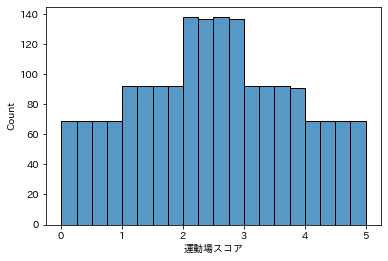

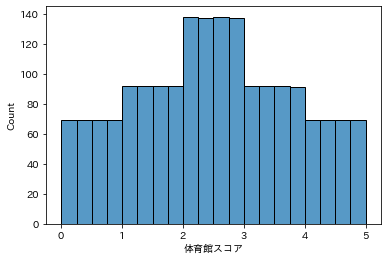

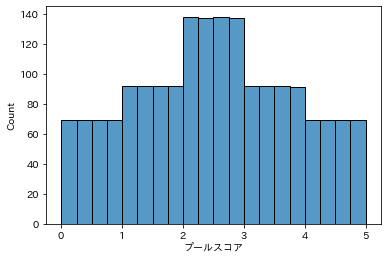

In [15]:
for feature_name in feature_list.keys():
    sns.histplot(df_pop_master[feature_name], bins=20)
    plt.show()

In [16]:
score_list = []
for key, value in feature_list.items():
    df_pop_master[f'{key}レベル'] = rank_score(df_pop_master[key] * value['sort'])
    score_list.append(df_pop_master[f'{key}レベル'] * value['weight'])

_tmp_score = pd.concat(score_list, axis=1).sum(axis=1) # skipna=False
df_pop_master[score_name] = rank_score(_tmp_score)

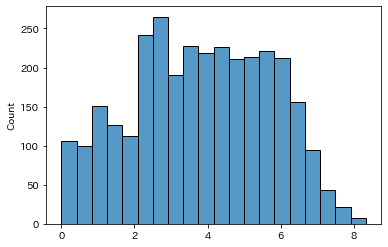

In [17]:
sns.histplot(_tmp_score, bins=20)
plt.show()

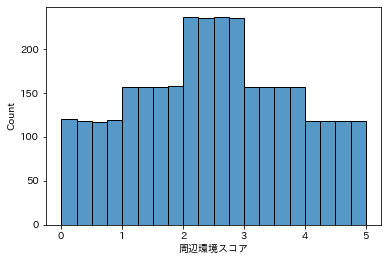

In [18]:
sns.histplot(df_pop_master[score_name], bins=20)
plt.show()

In [19]:
df_pop_master[score_name] = df_pop_master[score_name].round(3)

In [20]:
df_pop_master[
    list(feature_list.keys()) + [score_name]
].to_csv(os.path.join(DIR_NAME, output_score_file), index=True)

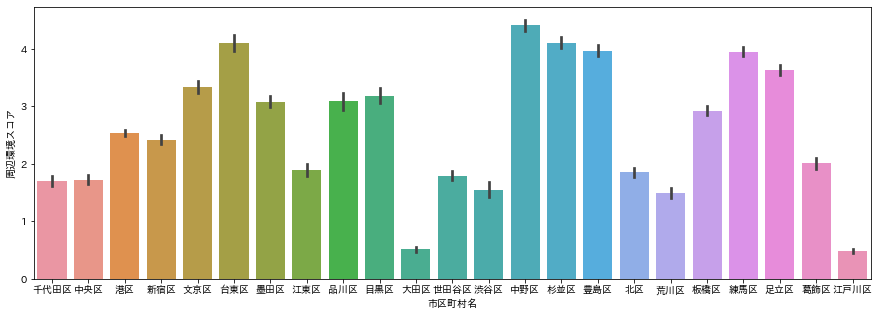

In [21]:
plt.figure(figsize=(15, 5))
sns.barplot(x='市区町村名', y=score_name, data=df_pop_master)
plt.show()

In [22]:
df_level = df_pop_master.copy()
df_level['rank'] = df_level.groupby('町名')[score_name].transform('rank', ascending=False)
df_level = df_level[df_level['rank'] == 1].sort_values(score_name, ascending=False)[
    ['市区町村名', '町名', '町丁目'] + list(feature_list.keys()) + [score_name]
].reset_index(drop=True)
print(df_level.shape)

(913, 8)


In [23]:
df_level.head(10)

,市区町村名,町名,町丁目,公園スコア,運動場スコア,体育館スコア,プールスコア,周辺環境スコア
0,台東区,浅草,浅草７丁目,4.733,4.938,2.488,4.568,5.000
1,杉並区,高円寺南,高円寺南１丁目,4.537,4.263,3.808,3.985,4.998
2,足立区,弘道,弘道１丁目,4.883,3.542,4.786,2.570,4.996
3,台東区,花川戸,花川戸２丁目,4.582,4.463,2.628,4.300,4.989
4,台東区,東浅草,東浅草１丁目,4.563,4.626,2.180,4.623,4.987
5,足立区,中央本町,中央本町２丁目,4.493,3.552,4.873,2.466,4.983
6,杉並区,高円寺北,高円寺北３丁目,4.743,4.169,3.103,2.753,4.979
7,杉並区,梅里,梅里１丁目,4.370,3.667,3.784,3.811,4.977
8,足立区,青井,青井２丁目,4.529,2.838,4.946,2.720,4.972
9,杉並区,和田,和田３丁目,4.176,4.006,3.542,4.067,4.970


In [24]:
df_level.tail(10)

,市区町村名,町名,町丁目,公園スコア,運動場スコア,体育館スコア,プールスコア,周辺環境スコア
903,大田区,萩中,萩中１丁目,0.151,NaN,NaN,NaN,0.119
904,大田区,南六郷,南六郷１丁目,0.102,NaN,NaN,NaN,0.098
905,大田区,本羽田,本羽田１丁目,0.085,NaN,NaN,NaN,0.083
906,大田区,京浜島,京浜島１丁目,0.059,NaN,NaN,NaN,0.064
907,大田区,羽田,羽田１丁目,0.049,NaN,NaN,NaN,0.055
908,大田区,羽田旭町,羽田旭町,0.040,NaN,NaN,NaN,0.049
909,大田区,城南島,城南島７丁目,0.025,NaN,NaN,NaN,0.034
910,大田区,羽田空港,羽田空港１丁目,0.017,NaN,NaN,NaN,0.025
911,大田区,羽田沖水面,羽田沖水面,NaN,NaN,NaN,NaN,0.005
912,大田区,ふるさとの浜辺公園,ふるさとの浜辺公園,NaN,NaN,NaN,NaN,0.005
